# Locate the Lane Lines

!['Thresholded and perspective transformed image'](warped-example.jpg)


## Processing Each Image

!['color-shadow-example.jpg'](color-shadow-example.jpg)

- first thing: compute the camera calibration matrix and distortion coefficients ONCE. 
- Apply them to undistort each new frame. 
- Apply thresholds to create a binary image 
- and then apply a perspective transform.

### Thresholding

- Try out various combinations of color and gradient thresholds to generate a binary image 
-- where the lane lines are clearly visible. 

- For example, given the image above, the output should look something like this:

!['binary-combo-img.jpg'](binary-combo-img.jpg)



### Perspective Transform

- Next, identify four source points for perspective transform. 
-- In this case, assume the road is a flat plane. This isn't strictly true, but it isan approximation for project. 
-- Pick four points in a trapezoidal shape (similar to region masking) that would represent a rectangle when looking down on the road from above.

- The easiest way to do this is to investigate an image where the lane lines are straight, 
-- and find four points lying along the lines

- after perspective transform, make the lines look straight and vertical from a bird's eye view perspective.

!['warped-straight-lines.jpg'](warped-straight-lines.jpg) 



### Now for curved lines

- Same four source points will now work to transform any image (again, under the assumption that the road is flat and the camera perspective hasn't changed). 

- When applying the transform to new images, the test of whether or not the transform correct, is that the lane lines should appear parallel in the warped images, whether they are straight or curved.

- Here's an example of applying a perspective transform to thresholded binary image, using the same source and destination points as above, showing that the curved lines are (more or less) parallel in the transformed image:

!['warped-curved-lines.jpg'](warped-curved-lines.jpg)

# Line Finding Method: Peaks in a Histogram

- After applying calibration, thresholding, and a perspective transform to a road image, 
-- we have a binary image where the lane lines stand out clearly. 

- However, we still need to decide explicitly which pixels are part of the lines 
-- and which belong to the left line and which belong to the right line.

- Plotting a histogram of where the binary activations occur across the image is one potential solution. 
- Let us take a couple quick steps to create our histogram!



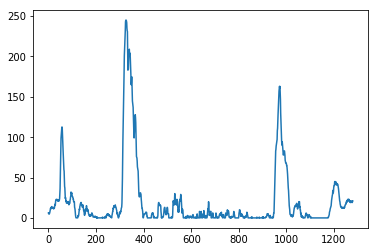

In [4]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img = mpimg.imread('warped-example.jpg')/255

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    half_rows = img.shape[0] //2;
    bottom_half = img[half_rows:,:]
    
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(img)

# Visualize the resulting histogram
plt.plot(histogram)

# Sliding Window

- With this histogram we are adding up the pixel values along each column in the image.
- In our thresholded binary image, pixels are either 0 or 1, 
 - so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. 
 - Hence we can use that as a starting point for where to search for the lines. 
 - From that point, we can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

- Here is a short animation showing this method:
[![sliding window](http://img.youtube.com/vi/siAMDK8C_x8/0.jpg)](https://youtu.be/siAMDK8C_x8 "sliding window")


# Implement Sliding Windows and Fit a Polynomial

!['mplement Sliding Windows and Fit a Polynomial'](sliding_window.png)

- Use the two highest peaks from  histogram as a starting point for determining where the lane lines are
    - then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go
    


### Split the histogram for the two lines

- The first step we'll take is to split the histogram into two sides, one for each lane line.

```python
import numpy as np
import cv2
import matplotlib.pyplot as plt

halfRows = binary_warped.shape[0]//2
hist = np.sum(binary_wraped[halfRows:,:], axis=0) 


# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
midpoint = histogram.shape[0]//2
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

```

### Set up windows and window hyperparameters

- Set a few hyperparameters related to our sliding windows, 
    - and set them up to iterate across the binary activations in the image. 
- We have some base hyperparameters below, but don't forget to try out different values in your own implementation to see what works best!

```python
 
# Choose the number of sliding windows
nwindows = 9

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(binary_warped.shape[0]//nwindows)

# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
```

### Iterate through `nwindows` to track curvature

- Now that we've set up what the windows look like and have a starting point, we'll want to loop for nwindows,
    - with the given window sliding left or right if it finds the mean position of activated pixels within the window to have shifted.


1. Loop through each window in nwindows
2. Find the boundaries of our current window. 
     - This is based on a combination of the current window's starting point (leftx_current and rightx_current), 
         - as well as the margin you set in the hyperparameters.
         
3. Use cv2.rectangle to draw these window boundaries onto our visualization image out_img. 
    - This is required for the quiz. Can skip this step in practice if you don't need to visualize where the windows are.

4. Now that we know the boundaries of our window, find out which activated pixels from nonzeroy and nonzerox above actually fall into the window.

5. Append these to our lists left_lane_inds and right_lane_inds.

6. If the number of pixels found in Step 4 are greater than hyperparameter minpix, re-center our window 
    - (i.e. leftx_current or rightx_current) based on the mean position of these pixels.

### Fit a polynomial

Now that we have found all our pixels belonging to each line through the sliding window method, it's time to fit a polynomial to the line. First, we have a couple small steps to ready our pixels.

```python

# Concatenate the arrays of indices (previously was a list of lists of pixels)
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]

rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

```

We'll implement the function for the polynomial in the quiz below using np.polyfit.

```python

# Assuming we have `left_fit` and `right_fit` from `np.polyfit` before
# Generate x and y values for plotting

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
```

### Visualization

```python
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

plt.imshow(out_img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.xlim(0, 1280)
plt.ylim(720, 0)
```


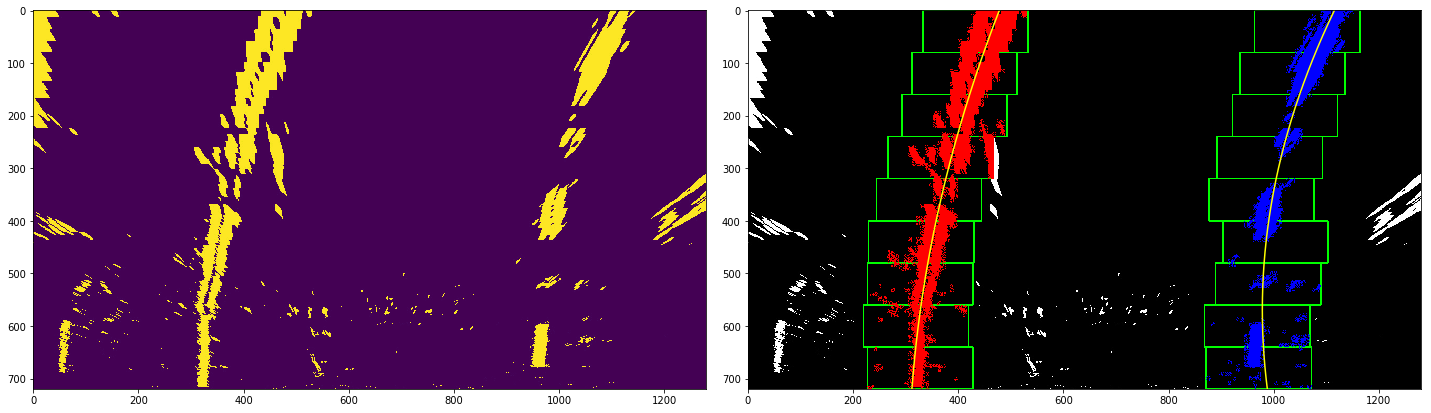

In [17]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

img = mpimg.imread('warped-example.jpg')

# img is an binary_warped image
def find_lane_lines(img):
    bottom_half = img.shape[0]//2
    hist = np.sum(img[bottom_half:,:], axis=0)
    out_img = np.dstack((img, img, img))
    
    # The peak of the left and right halves of the histogram
    midpoint = np.int(hist.shape[0]//2)
    leftx_base  = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    
    # HYPERPARAMETERS: number of sliding windows
    nwindows = 9
    
    # Width of the windows +/- margin
    margin = 100
    
    # Mimimum number of pixels found to re-center window
    minpix = 50
    
    window_height = np.int(img.shape[0]//nwindows)
    
    # x and y positions of all nonzero pixel in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base        
    for window in range(nwindows):
        
        # left and right window boundaries in x and y
        win_y_low  = img.shape[0]  - (window+1)*window_height
        win_y_high = img.shape[0]  -  window*window_height
        
        win_xleft_low  = leftx_current - margin
        win_xleft_high = leftx_current + margin
        
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img, (win_xleft_low,  win_y_low),
                               (win_xleft_high, win_y_high), (0,255,0), 2)
        
        cv2.rectangle(out_img, (win_xright_low,  win_y_low),
                               (win_xright_high, win_y_high), (0,255,0), 2)        
        
        good_left_inds = []
        good_right_inds = []
        
        ## TODO: No need to scan whole image here.
        for i in range(len(nonzeroy)):
            if nonzeroy[i] >= win_y_low and nonzeroy[i] <= win_y_high:
                if nonzerox[i] >= win_xleft_low  and nonzerox[i] <= win_xleft_high:
                    good_left_inds.append(i)                    
                if nonzerox[i] >= win_xright_low and nonzerox[i] <= win_xright_high:
                    good_right_inds.append(i)
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        if len(good_left_inds)  > minpix:
            leftx_current  = np.int(np.mean(nonzerox[good_left_inds])) 
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(img):
    leftx, lefty, rightx, righty, out_img = find_lane_lines(img)

    # Fit a second order polynomial 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('I failed to fit a line!!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Color in left and right lane pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return ploty, left_fitx, right_fitx, out_img


ploty, left_fitx, right_fitx, out_img = fit_polynomial(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 16))
f.tight_layout()

ax1.imshow(img)
ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')